# Benchmarking simple CDR3 Beta Levenshtein distance

## Setup

In [1]:
import os
from pathlib import Path
import sys

if '__project_dir__' not in globals():
    __project_dir__ = Path.cwd().parent.resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [2]:
from itertools import combinations
import json
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, notna
from pathlib import Path
from rapidfuzz.process import cdist
from rapidfuzz.distance import Levenshtein
import seaborn
import torch
from tqdm import tqdm

seaborn.set_theme()
seaborn.set_style('white')

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

### Create benchmarking directory

In [4]:
BENCHMARK_DIR = Path(f'benchmarks_beta/cdr3_levenshtein')
if not BENCHMARK_DIR.is_dir():
    BENCHMARK_DIR.mkdir()

### Create cache directory

In [5]:
CACHE_DIR = BENCHMARK_DIR/'.cache'
if not CACHE_DIR.is_dir():
    CACHE_DIR.mkdir()

### Load data

In [6]:
back_df = pd.read_csv('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/tanno/test_beta.csv').iloc[:10000]
ep_df = pd.read_csv('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/vdjdb/evaluation_beta.csv')

back_df = back_df[['CDR3B']]
ep_df = ep_df[['CDR3B', 'Epitope']]

In [7]:
epitope_cat_codes = torch.tensor(ep_df['Epitope'].astype('category').cat.codes).to(device)

## Calculate alignment and uniformity

In [8]:
if (CACHE_DIR/'ep_cdist.pt').is_file():
    ep_cdist = torch.load(CACHE_DIR/'ep_cdist.pt').to(device)
else:
    ep_cdist = cdist(ep_df['CDR3B'], ep_df['CDR3B'], scorer=Levenshtein.distance)
    ep_cdist = torch.tensor(ep_cdist, dtype=torch.float32)
    torch.save(ep_cdist.cpu(), CACHE_DIR/'ep_cdist.pt')

In [9]:
if (CACHE_DIR/'back_cdist.pt').is_file():
    back_cdist = torch.load(CACHE_DIR/'back_cdist.pt').to(device)
else:
    back_cdist = cdist(back_df['CDR3B'], back_df['CDR3B'], scorer=Levenshtein.distance)
    back_cdist = torch.tensor(back_cdist, dtype=torch.float32)
    torch.save(back_cdist.cpu(), CACHE_DIR/'back_cdist.pt')

In [10]:
ep_alignments = []

for i in range(46):
    start_idx = i*100
    end_idx = (i+1)*100
    ep_view = ep_cdist[start_idx:end_idx,start_idx:end_idx]

    ep_alignments.append((ep_view.sum() / (100 * 99)).item())

alignment = torch.tensor(ep_alignments).mean().item()

In [11]:
back_cdist_neg_exp = back_cdist.mul(-1).exp()
uniformity_exp = back_cdist_neg_exp.sum() / (10000 * 9999)
uniformity = uniformity_exp.log().item()

## k-NN evaluation

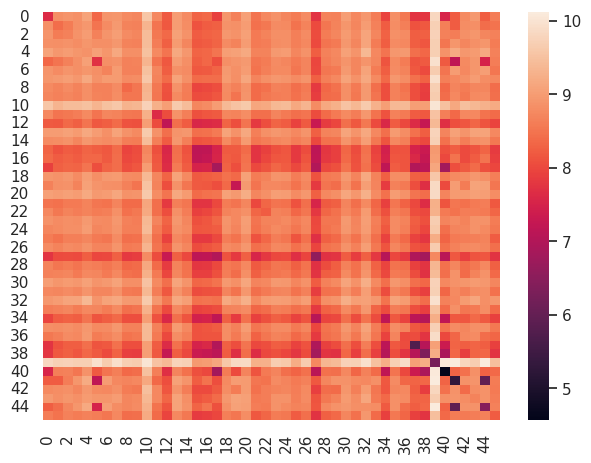

In [12]:
avg_dist_in_group = torch.nn.functional.avg_pool2d(ep_cdist.unsqueeze(0),100).squeeze(0)
scaling_factor = torch.ones(46,46).fill_diagonal_(100/99).to(device)
avg_dist_in_group *= scaling_factor

c_dist_map = seaborn.heatmap(avg_dist_in_group.cpu().detach().numpy())
plt.tight_layout()
plt.savefig(BENCHMARK_DIR/'cdists.png')
plt.show()

In [13]:
ep_cdist.fill_diagonal_(torch.inf)

tensor([[inf, 11.,  7.,  ...,  8.,  9.,  8.],
        [11., inf, 11.,  ..., 13., 11., 13.],
        [ 7., 11., inf,  ...,  8.,  6.,  6.],
        ...,
        [ 8., 13.,  8.,  ..., inf,  7.,  6.],
        [ 9., 11.,  6.,  ...,  7., inf,  8.],
        [ 8., 13.,  6.,  ...,  6.,  8., inf]], device='cuda:0')

In [14]:
knn_scores = dict()

for k in (5, 10, 50, 100):
    scores = []
    ep_size = len(ep_df)

    for tcr_index in tqdm(range(ep_size)):
        # Get correct epitope label
        expected = epitope_cat_codes[tcr_index]

        # Get list of distances for that TCR
        dists = ep_cdist[tcr_index]

        # Get indices of nearest neighbours
        _, idcs = torch.topk(dists, k=k, largest=False)

        # Get epitopes of nearest neighbours
        knn_cat_codes = epitope_cat_codes[idcs]

        # Predict epitope
        pred, _ = torch.mode(knn_cat_codes)

        # Record score
        scores.append(expected.item() == pred.item())

    score = torch.tensor(scores, dtype=torch.float32).mean().item()

    print(f'{k}-NN score: {score}')

    knn_scores[k] = score

100%|██████████| 4600/4600 [00:00<00:00, 7968.38it/s]


5-NN score: 0.26108697056770325


100%|██████████| 4600/4600 [00:00<00:00, 10301.40it/s]


10-NN score: 0.2676087021827698


100%|██████████| 4600/4600 [00:00<00:00, 9819.98it/s]


50-NN score: 0.21760869026184082


100%|██████████| 4600/4600 [00:00<00:00, 9815.23it/s]

100-NN score: 0.19826087355613708


## Write out evaluation metrics to json

In [15]:
metrics_dict = {
    'model_name': 'cdr3_levenshtein',
    'alignment': alignment,
    'uniformity': uniformity,
    'knn_scores': knn_scores
}

In [16]:
with open(BENCHMARK_DIR/'metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)